**Data Preparation and Preprocessing for Image Classification**

In [2]:
import os
import random
from shutil import copytree
from shutil import copyfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
from matplotlib import pyplot as plt


def split_dataset(source_folder, train_folder, test_folder, split_ratio=0.8):

    
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    
    subfolders = [f.path for f in os.scandir(source_folder) if f.is_dir()]

    for folder in subfolders:
        folder_name = os.path.basename(folder)
        train_folder_path = os.path.join(train_folder, folder_name)
        test_folder_path = os.path.join(test_folder, folder_name)

        if not os.path.exists(train_folder_path):
            os.makedirs(train_folder_path)
        if not os.path.exists(test_folder_path):
            os.makedirs(test_folder_path)

        all_files = os.listdir(folder)
        random.shuffle(all_files)
        split_index = int(len(all_files) * split_ratio)

        for file_name in all_files[:split_index]:
            source_path = os.path.join(folder, file_name)
            destination_path = os.path.join(train_folder_path, file_name)
            if os.path.isfile(source_path):
                copyfile(source_path, destination_path)
            else:
                copytree(source_path, destination_path)

        for file_name in all_files[split_index:]:
            source_path = os.path.join(folder, file_name)
            destination_path = os.path.join(test_folder_path, file_name)
            if os.path.isfile(source_path):
                copyfile(source_path, destination_path)
            else:
                copytree(source_path, destination_path)

source_folder = 'C:/AI/Data-set'
train_folder = 'C:/AI/source-dataset/train'
test_folder = 'C:/AI/source-dataset/test'

if os.path.exists(train_folder) or os.path.exists(test_folder):
    train_count = len(os.listdir(train_folder)) if os.path.exists(train_folder) else 0
    test_count = len(os.listdir(test_folder)) if os.path.exists(test_folder) else 0
    print("Train & Test folders already exist")
else:
    split_dataset(source_folder, train_folder, test_folder, split_ratio=0.8)


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]) 
])
train_dataset =  datasets.ImageFolder(root=train_folder, transform=transform)
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



**Visualizing Sample Images from the Training Dataset**

{'Kordi': 0, 'lori': 1, 'torkaman': 2}


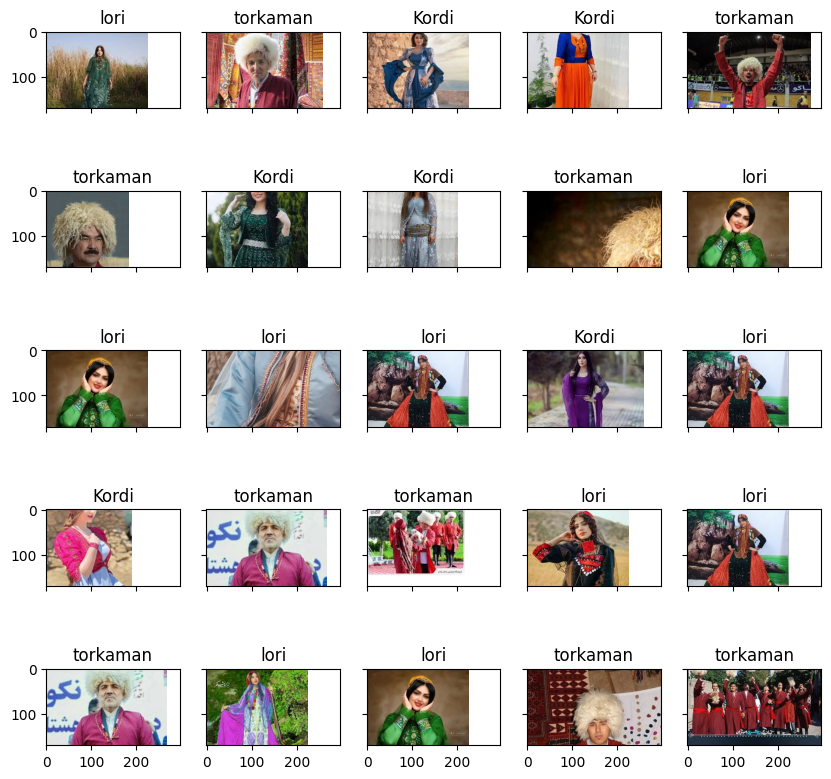

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

class_names = test_dataset.classes

fig, ax = plt.subplots(5, 5, figsize=(10, 10), sharex=True, sharey=True)
print(train_dataset.class_to_idx)
for i in range(5):
    for j in range(5):
        random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
        img_path, label = train_dataset.samples[random_idx]
        image = Image.open(img_path)
        ax[i][j].imshow(image)
        ax[i][j].set_title(class_names[label])
plt.show()

**Convolutional Neural Network (CNN) for Image Classification**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu"


class image_CNN(nn.Module):
    def __init__(self):
        super(image_CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(32768, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 3) 
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        n_size = x.size(1) * x.size(2) * x.size(3)
        
        x = x.view(-1, n_size)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x



model = image_CNN()
model = model.to(device)

dummy_input = torch.randn(1, 1, 128, 128).to(device)  # Batch size of 1
dummy_output = model(dummy_input)
dummy_output = dummy_output.to(device)
print(dummy_output.size())

print(model)

torch.Size([1, 3])
image_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)


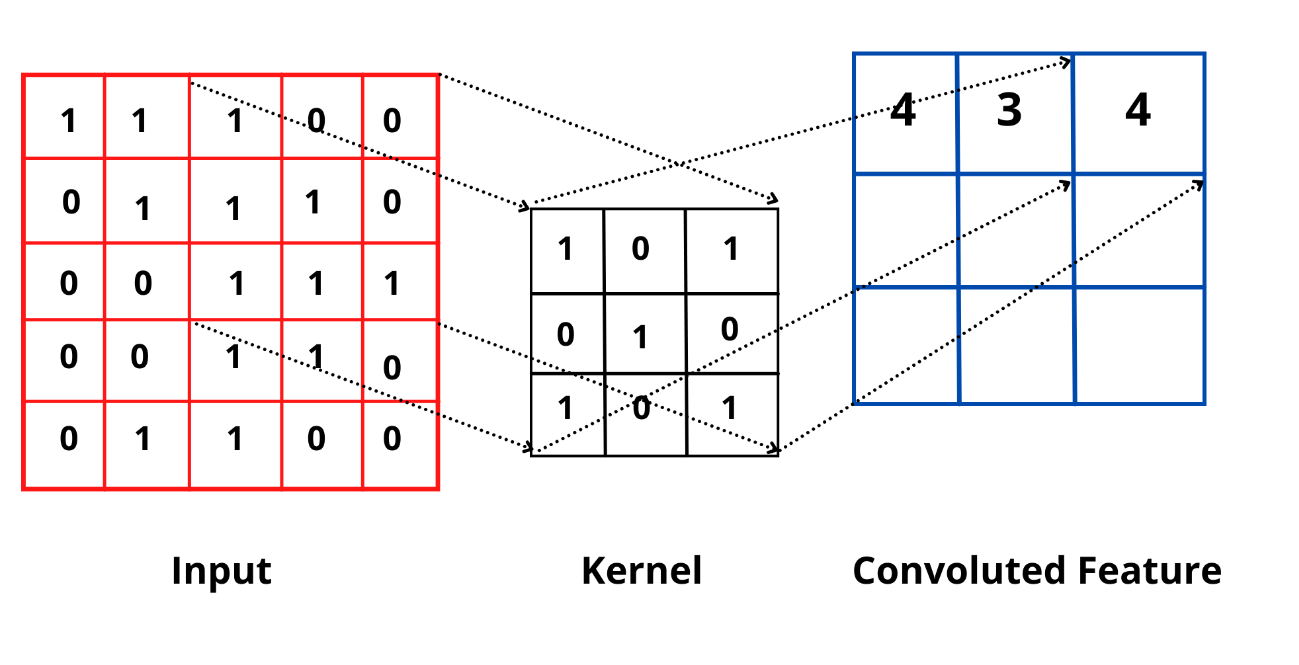

**Loss Function and Optimizer Setup**

In [8]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

**Training and Evaluation Loop for CNN Image Classifier**

In [9]:
epochs = 50
train_loss_history = []
train_accuracies_history  = []
test_loss_history = []
test_accuracies_history = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(output, 1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    train_loss_history.append(train_loss)
    train_accuracies_history.append(train_acc)
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.inference_mode():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            loss = loss_function(output, labels)
            test_loss += loss.item()
            test_acc += (torch.argmax(output, 1) == labels).sum().item()
    test_loss /= len(test_loader.dataset)
    test_acc /= len(test_loader.dataset)
    test_loss_history.append(test_loss)
    test_accuracies_history.append(test_acc)
    print(f'Epoch {epoch + 1}/{epochs} '
        f'Train Accuracy: {train_acc * 100:.2f}% '
        f'-- test Accuracy: {test_acc * 100:.2f}%')

Epoch 1/50 Train Accuracy: 32.50% -- test Accuracy: 43.33%
Epoch 2/50 Train Accuracy: 41.67% -- test Accuracy: 66.67%
Epoch 3/50 Train Accuracy: 35.83% -- test Accuracy: 63.33%
Epoch 4/50 Train Accuracy: 49.17% -- test Accuracy: 53.33%
Epoch 5/50 Train Accuracy: 45.00% -- test Accuracy: 56.67%
Epoch 6/50 Train Accuracy: 46.67% -- test Accuracy: 60.00%
Epoch 7/50 Train Accuracy: 50.00% -- test Accuracy: 63.33%
Epoch 8/50 Train Accuracy: 52.50% -- test Accuracy: 66.67%
Epoch 9/50 Train Accuracy: 62.50% -- test Accuracy: 70.00%
Epoch 10/50 Train Accuracy: 60.00% -- test Accuracy: 66.67%
Epoch 11/50 Train Accuracy: 55.00% -- test Accuracy: 63.33%
Epoch 12/50 Train Accuracy: 55.83% -- test Accuracy: 63.33%
Epoch 13/50 Train Accuracy: 68.33% -- test Accuracy: 73.33%
Epoch 14/50 Train Accuracy: 65.83% -- test Accuracy: 70.00%
Epoch 15/50 Train Accuracy: 64.17% -- test Accuracy: 76.67%
Epoch 16/50 Train Accuracy: 66.67% -- test Accuracy: 73.33%
Epoch 17/50 Train Accuracy: 69.17% -- test Accura

**Training and Test Accuracy Visualization**

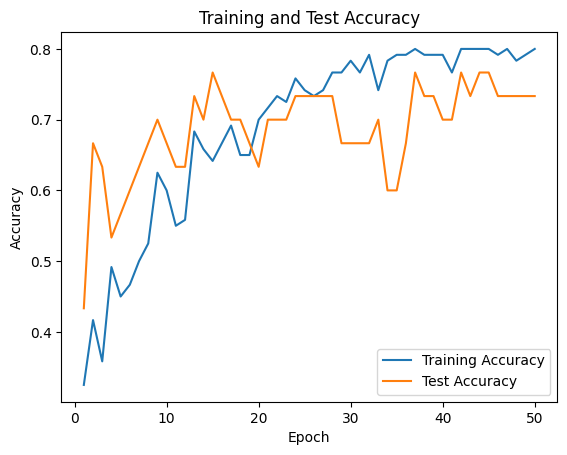

In [10]:
import matplotlib.pyplot as plt
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, train_accuracies_history, label='Training Accuracy')
plt.plot(epochs_range, test_accuracies_history, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


**Image Prediction Using Pretrained CNN Model**

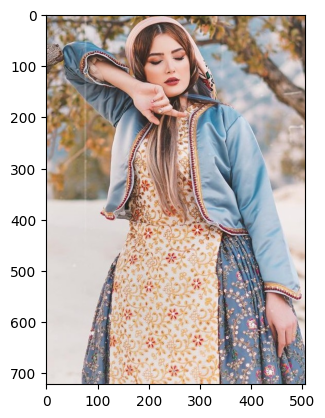

Prediction: lori


In [14]:

import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]) 
])

image_path = '689dcc3253bc8f43504943d6c8b6e5e1.jpg'
image = Image.open(image_path)
plt.imshow(image)
plt.show()

image = transform(image)
image = image.unsqueeze(0)
image = image
model.eval()

with torch.no_grad():
    output = model(image)
    prediction = torch.argmax(output, 1).item()
    print(f'Prediction: {class_names[prediction]}')
